In [7]:
!pip install opendatasets

Defaulting to user installation because normal site-packages is not writeable


In [8]:
import opendatasets as od

In [9]:
od.download('https://www.kaggle.com/datasets/sousablde/311-nyc-open-data-hpd')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:Your Kaggle Key:Downloading 311-nyc-open-data-hpd.zip to ./311-nyc-open-data-hpd


100%|██████████| 306M/306M [00:41<00:00, 7.69MB/s] 


In [10]:
!pip install geopandas missingno imblearn

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 2.6 MB/s eta 0:00:00m eta 0:00:010:01:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 10.1 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 10.4 MB/s eta 0:00:00m eta 0:00:010:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 11.2 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.3/199.3 kB 2.0 MB/s eta 0:00:000:00:01


In [11]:
import numpy as np
import pandas as pd
import geopandas as gpd
import missingno as msno

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%config InlineBackend.figure_format = 'retina'

from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, StratifiedKFold, learning_curve
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

label_size = 17
plt.rcParams['axes.labelsize'] = label_size
plt.rcParams['axes.titlesize'] = label_size
plt.rcParams['xtick.labelsize'] = label_size - 3  # tick labels should be smaller than axes labels (by 3 in our case)
plt.rcParams['ytick.labelsize'] = label_size - 3

random_state = 42
scoring_metric = 'accuracy'

print ('Libraries Loaded!')

Libraries Loaded!


/home/dingo/.local/lib/python3.10/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/dingo/.local/lib/python3.10/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(


In [13]:
df = pd.read_csv('311-nyc-open-data-hpd/fhrw-4uyv.csv', 
                 parse_dates = ['created_date', 'closed_date'])

df['Year'] = df['created_date'].dt.year

print('The 311 Dataset contains {} rows and {} columns.'.format(df.shape[0], df.shape[1]))
df.head()

The 311 Dataset contains 5846787 rows and 16 columns.


,created_date,unique_key,complaint_type,incident_zip,incident_address,street_name,address_type,city,resolution_description,borough,latitude,longitude,closed_date,location_type,status,Year
0,2019-08-23 12:35:54,43624241,HEAT/HOT WATER,10032.0,560 WEST 160 STREET,WEST 160 STREET,ADDRESS,NEW YORK,The complaint you filed is a duplicate of a co...,MANHATTAN,40.835396,-73.942262,NaT,RESIDENTIAL BUILDING,Open,2019
1,2019-08-23 08:43:58,43623659,UNSANITARY CONDITION,11208.0,261 MONTAUK AVENUE,MONTAUK AVENUE,ADDRESS,BROOKLYN,The following complaint conditions are still o...,BROOKLYN,40.672494,-73.877521,NaT,RESIDENTIAL BUILDING,Open,2019
2,2019-08-23 09:08:09,43624463,UNSANITARY CONDITION,10002.0,125 MADISON STREET,MADISON STREET,ADDRESS,NEW YORK,The following complaint conditions are still o...,MANHATTAN,40.712353,-73.993947,NaT,RESIDENTIAL BUILDING,Open,2019
3,2019-08-23 16:36:08,43625072,DOOR/WINDOW,11211.0,525 UNION AVENUE,UNION AVENUE,ADDRESS,BROOKLYN,The following complaint conditions are still o...,BROOKLYN,40.716233,-73.951986,NaT,RESIDENTIAL BUILDING,Open,2019
4,2019-08-23 11:15:00,43623738,UNSANITARY CONDITION,11372.0,35-52F 73 STREET,73 STREET,ADDRESS,Jackson Heights,NaN,QUEENS,40.750533,-73.892998,NaT,RESIDENTIAL BUILDING,Open,2019


In [14]:
def plot_learning_curve(estimator, estimator_name, X, y, ax, cv = None, train_sizes = np.linspace(0.1, 1.0, 5)):
                 
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv = cv, n_jobs = -1, 
                                                            train_sizes = train_sizes, scoring = 'accuracy')
    
    train_scores_mean, train_scores_std = np.mean(train_scores, axis = 1), np.std(train_scores, axis = 1)
    test_scores_mean, test_scores_std = np.mean(test_scores, axis = 1), np.std(test_scores, axis = 1)
            
    ax.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha = 0.1, color = 'dodgerblue')
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha = 0.1, color = 'darkorange')
    
    ax.plot(train_sizes, train_scores_mean, color = 'dodgerblue', marker = 'o', linestyle = '-', label = 'Training Score')
    ax.plot(train_sizes, test_scores_mean, color = 'darkorange', marker = 'o', linestyle = '-', label = 'Cross-validation Score')
    ax.set_title(estimator_name)
    ax.set_xlabel('Training Examples')
    ax.set_ylabel('Accuracy Score')
    ax.legend(loc = 'best');
    
def clf_performance(clf, clf_name):
    
    cv_scores = cross_val_score(clf, X_train, y_train, 
                                cv = StratifiedKFold(shuffle = True, random_state = random_state))
    
    print (clf_name)
    print('-------------------------------')
    print ('CV scores: ', cv_scores)
    print ('     Mean: ', np.round(cv_scores.mean(), 3))
    print ('      STD: ', np.round(cv_scores.std(), 3))
    
    y_pred_pp = cross_val_predict(clf, X_train, y_train, cv = 5, method = 'predict_proba')[:, 1]
    y_pred = y_pred_pp.round()
    
    cm = confusion_matrix(y_train, y_pred, normalize = 'true')
    fpr, tpr, _ = roc_curve(y_train, y_pred_pp)
    auc = roc_auc_score(y_train, y_pred_pp)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 5))
    
    sns.heatmap(cm, annot = True, cmap = 'Blues', annot_kws = {'fontsize': 18}, ax = ax1)
    ax1.set_xlabel('Predicted Label')
    ax1.set_xticks([0.5, 1.5])
    ax1.set_xticklabels(['0', '1'])
    ax1.set_ylabel('True Label') 
    ax1.set_yticks([0.5, 1.5])
    ax1.set_yticklabels(['0', '1'])
    
    plot_learning_curve(clf, clf_name, X_train, y_train, ax2, cv = StratifiedKFold(shuffle = True, random_state = random_state))
    plt.tight_layout()
    
    return fpr, tpr, auc

def plot_feature_imp(classifier, classifier_name, color, ax):
  importances = pd.DataFrame({'Feature': X.columns,
                                'Importance': np.round(classifier.feature_importances_, 3)})

  importances = importances.sort_values('Importance', ascending = True).set_index('Feature')

  importances.plot.barh(color = color, edgecolor = 'firebrick', legend = False, ax = ax)
  ax.set_title(classifier_name)
  ax.set_xlabel('Importance');
    
print('Functions defined!')

Functions defined!


Question 1:
Exploratory Data Analysis

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5846787 entries, 0 to 5846786
Data columns (total 16 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   created_date            datetime64[ns]
 1   unique_key              int64         
 2   complaint_type          object        
 3   incident_zip            float64       
 4   incident_address        object        
 5   street_name             object        
 6   address_type            object        
 7   city                    object        
 8   resolution_description  object        
 9   borough                 object        
 10  latitude                float64       
 11  longitude               float64       
 12  closed_date             datetime64[ns]
 13  location_type           object        
 14  status                  object        
 15  Year                    int64         
dtypes: datetime64[ns](2), float64(3), int64(2), object(9)
memory usage: 713.7+ MB


In [16]:
print ('There are {} different complaint types.'.format(df['complaint_type'].nunique()))

There are 29 different complaint types.


In [17]:
df['complaint_type'].value_counts()

HEAT/HOT WATER            1149978
HEATING                    887869
PLUMBING                   702046
GENERAL CONSTRUCTION       500863
UNSANITARY CONDITION       434830
PAINT - PLASTER            361258
PAINT/PLASTER              340753
ELECTRIC                   303115
NONCONST                   260890
DOOR/WINDOW                199443
WATER LEAK                 186913
GENERAL                    145825
FLOORING/STAIRS            135159
APPLIANCE                  109480
HPD Literature Request      52830
SAFETY                      49904
OUTSIDE BUILDING             7015
ELEVATOR                     6397
Unsanitary Condition         5499
CONSTRUCTION                 5078
General                      1163
Safety                        424
STRUCTURAL                     16
Plumbing                       11
AGENCY                          9
VACANT APARTMENT                8
Outside Building                6
Appliance                       4
Mold                            1
Name: complain

In [18]:
df.loc[df['complaint_type'] == 'HEATING', 'complaint_type'] = 'HEAT/HOT WATER'
df.loc[df['complaint_type'] == 'PAINT - PLASTER', 'complaint_type'] = 'PAINT/PLASTER'
df.loc[df['complaint_type'] == 'PLUMBING', 'complaint_type'] = 'PLUMBING'

# or
# df['Complaint Type'] = np.where(df['Complaint Type'] == 'HEATING','HEAT/HOT WATER', df['Complaint Type'])

print ('Top 5 complaints:')
df['complaint_type'].value_counts().head()

Top 5 complaints:


HEAT/HOT WATER          2037847
PLUMBING                 702046
PAINT/PLASTER            702011
GENERAL CONSTRUCTION     500863
UNSANITARY CONDITION     434830
Name: complaint_type, dtype: int64

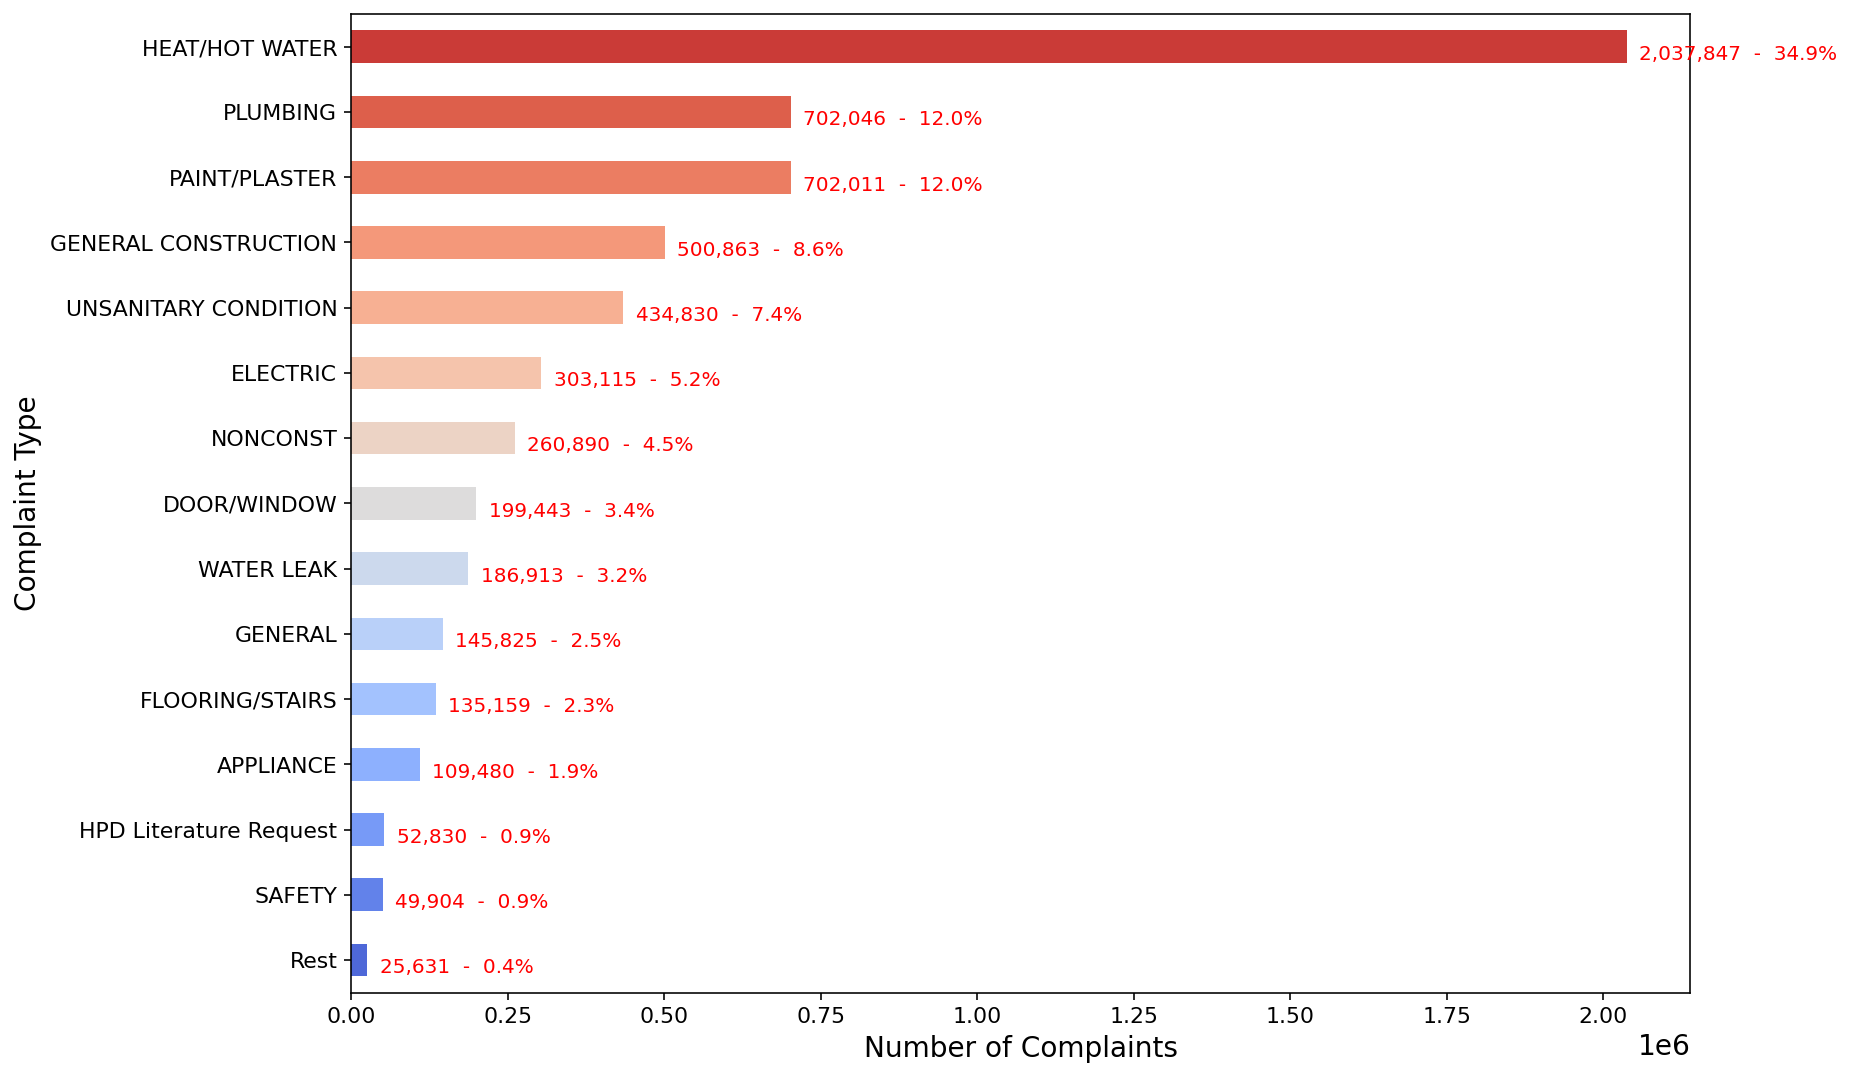

In [19]:
df_new = df.copy()

# find the name of the less common complaints and rename all corresponding rows
idx = df['complaint_type'].value_counts().sort_values().head(13).index
df_new.loc[df_new['complaint_type'].isin(idx), 'complaint_type'] = 'Rest'

df_complaints = df_new['complaint_type'].value_counts().sort_values()

df_complaints.plot(kind = 'barh', figsize = (12, 9), fontsize = 11, color = sns.color_palette('coolwarm', len(df_complaints)))
plt.ylabel('Complaint Type', fontsize = 14)
plt.xlabel('Number of Complaints', fontsize = 14)

# Includes the number of incidents and the corresponding percentage for every type
for index, value in enumerate(df_complaints):    
    label = str(format(int(value), ',')) + '  -  {}%'.format(round( (value/df_complaints.sum())*100, 1)) 
    plt.annotate(label, xy = (value + 20000, index - 0.2 ), color = 'red')

In [20]:
df_tc = df[['borough', 'incident_zip', 'street_name', 'latitude', 'longitude', 'complaint_type']]
df_tc = df_tc[((df_tc['complaint_type'] == 'PAINT/PLASTER') | (df_tc['complaint_type'] == 'PLUMBING') | (df_tc['complaint_type'] == 'HEAT/HOT WATER'))]

print(df_tc.head())
print(df_tc['complaint_type'].value_counts().head())
print(df_tc.shape[0], df_tc.shape[1])

      borough  incident_zip           street_name   latitude  longitude  \
0   MANHATTAN       10032.0      WEST  160 STREET  40.835396 -73.942262   
6       BRONX       10469.0  PELHAM PARKWAY NORTH  40.858298 -73.854455   
7   MANHATTAN       10027.0              7 AVENUE  40.807961 -73.949077   
18      BRONX       10454.0      EAST  139 STREET  40.807957 -73.918059   
19  MANHATTAN       10026.0      WEST  113 STREET  40.801529 -73.954533   

    complaint_type  
0   HEAT/HOT WATER  
6         PLUMBING  
7         PLUMBING  
18   PAINT/PLASTER  
19  HEAT/HOT WATER  
HEAT/HOT WATER    2037847
PLUMBING           702046
PAINT/PLASTER      702011
Name: complaint_type, dtype: int64
3441904 6


In [21]:

missing_counts = df_tc.isnull().sum().sort_values(ascending = False)
percent = (df_tc.isnull().sum()*100/df_tc.shape[0]).sort_values(ascending = False)

missing_df = pd.concat([missing_counts, percent], axis = 1, keys = ['Counts', '%'])
print('Missing values: ')
missing_df.head()

Missing values: 


,Counts,%
incident_zip,22755,0.661117
latitude,22739,0.660652
longitude,22739,0.660652
street_name,1,0.000029
borough,0,0.000000


In [22]:
df_tc['borough'].value_counts()

BROOKLYN         952652
BRONX            939166
MANHATTAN        623010
Unspecified      525285
QUEENS           362088
STATEN ISLAND     39703
Name: borough, dtype: int64

In [23]:
df_tc = df_tc[df_tc['borough'] != 'Unspecified']
df_tc['borough'].value_counts()

BROOKLYN         952652
BRONX            939166
MANHATTAN        623010
QUEENS           362088
STATEN ISLAND     39703
Name: borough, dtype: int64

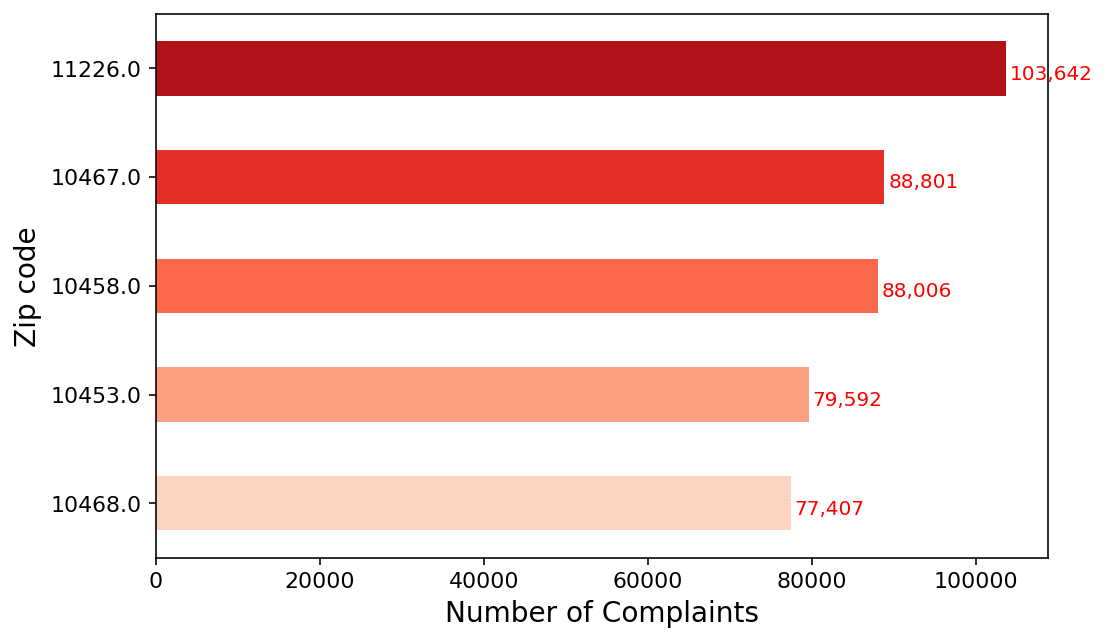

In [24]:
ny_zip = df_tc['incident_zip'].value_counts().head(5).sort_values()
ny_zip.index = ny_zip.index.map(str)
color = sns.color_palette('Reds', len(ny_zip))

ny_zip.plot(kind = 'barh', figsize = (8, 5), fontsize = 11, color = color)
plt.ylabel('Zip code', fontsize = 14)
plt.xlabel('Number of Complaints', fontsize = 14)

for index, value in enumerate(ny_zip):   
    label = str(format(int(value), ',')) 
    plt.annotate(label, xy = (value + 500, index - 0.1), color = 'red')

In [25]:
print('11226 Zip code belongs to: ', df[df['incident_zip'] == 11226.0].head().iloc[0]['borough'])

11226 Zip code belongs to:  BROOKLYN


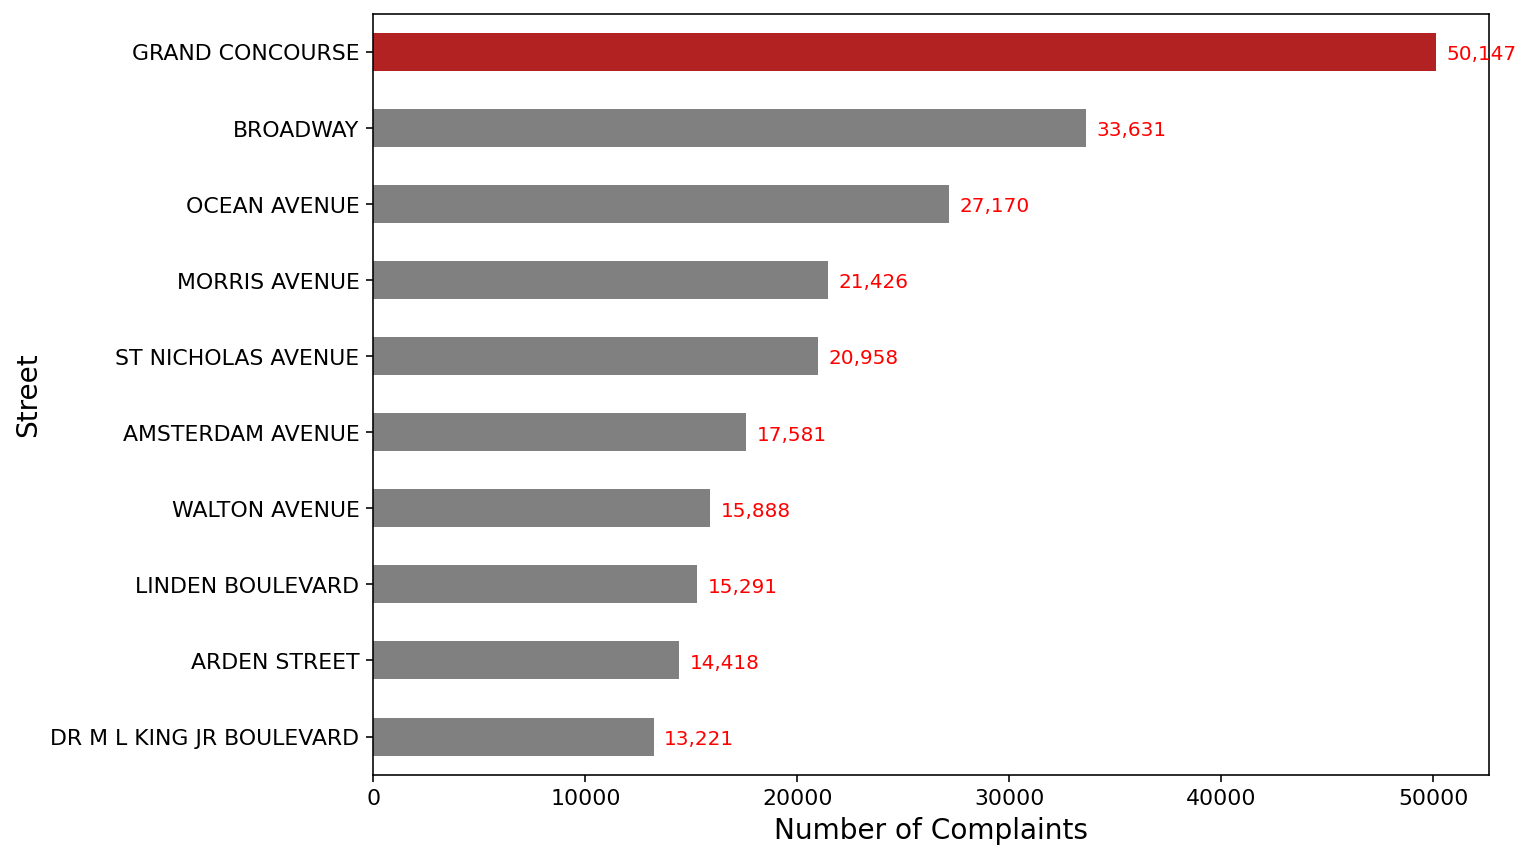

In [26]:
colors = ['Grey', 'Grey', 'Grey', 'Grey', 'Grey', 'Grey', 'Grey', 'Grey', 'Grey', 'firebrick']
ny_streets = df_tc['street_name'].value_counts().head(10).sort_values()

ny_streets.plot(kind = 'barh', figsize = (10, 7), fontsize = 11, color = colors)
plt.ylabel('Street', fontsize = 14)
plt.xlabel('Number of Complaints', fontsize = 14)

for index, value in enumerate(ny_streets):   
    label = str(format(int(value), ',')) 
    plt.annotate(label, xy = (value + 500, index - 0.1), color = 'red')

In [27]:
print('Grand Concourse\n\tBorough: ', df[df['street_name'] == 'GRAND CONCOURSE'].iloc[0]['borough'])

Grand Concourse
	Borough:  BRONX


In [28]:
df_311_BX = df[(((df['complaint_type'] == 'PLUMBING') & (df['borough'] == 'BRONX')) | ((df['complaint_type'] == 'PAINT/PLASTER') & (df['borough'] == 'BRONX')) | ((df['complaint_type'] == 'HEAT/HOT WATER') & (df['borough'] == 'BRONX')))].reset_index(drop = True)
df_311_BX.head()

,created_date,unique_key,complaint_type,incident_zip,incident_address,street_name,address_type,city,resolution_description,borough,latitude,longitude,closed_date,location_type,status,Year
0,2019-08-23 09:21:00,43624528,PLUMBING,10469.0,1135 PELHAM PARKWAY NORTH,PELHAM PARKWAY NORTH,ADDRESS,BRONX,The following complaint conditions are still o...,BRONX,40.858298,-73.854455,NaT,RESIDENTIAL BUILDING,Open,2019
1,2019-08-23 16:02:06,43623907,PAINT/PLASTER,10454.0,533 EAST 139 STREET,EAST 139 STREET,ADDRESS,BRONX,The following complaint conditions are still o...,BRONX,40.807957,-73.918059,NaT,RESIDENTIAL BUILDING,Open,2019
2,2019-08-23 13:22:04,43623579,PAINT/PLASTER,10472.0,1364 BRONX RIVER AVENUE,BRONX RIVER AVENUE,ADDRESS,BRONX,The following complaint conditions are still o...,BRONX,40.833257,-73.880178,NaT,RESIDENTIAL BUILDING,Open,2019
3,2019-08-23 05:38:57,43626497,HEAT/HOT WATER,10462.0,1910 BENEDICT AVENUE,BENEDICT AVENUE,ADDRESS,BRONX,The complaint you filed is a duplicate of a co...,BRONX,40.834061,-73.860178,NaT,RESIDENTIAL BUILDING,Open,2019
4,2019-08-23 11:00:14,43624766,PAINT/PLASTER,10455.0,729 UNION AVENUE,UNION AVENUE,ADDRESS,BRONX,The following complaint conditions are still o...,BRONX,40.817256,-73.903715,NaT,RESIDENTIAL BUILDING,Open,2019


In [29]:
df_311_BX['complaint_type'].value_counts().head()

HEAT/HOT WATER    569194
PAINT/PLASTER     193062
PLUMBING          176910
Name: complaint_type, dtype: int64

In [30]:
columns = ['Address', 'BldgArea', 'BldgDepth', 'BuiltFAR', 'CommFAR', 'FacilFAR', 'Lot', 'LotArea', 'LotDepth', 
           'NumBldgs', 'NumFloors', 'OfficeArea', 'ResArea', 'ResidFAR', 'RetailArea', 'YearBuilt', 'YearAlter1', 
           'ZipCode', 'YCoord', 'XCoord']

df_pluto_BX = pd.read_csv('./311-nyc-open-data-hpd/BX_18v1.csv', usecols = columns)
df_pluto_BX.head()

,Lot,ZipCode,Address,LotArea,BldgArea,ResArea,OfficeArea,RetailArea,NumBldgs,NumFloors,LotDepth,BldgDepth,YearBuilt,YearAlter1,BuiltFAR,ResidFAR,CommFAR,FacilFAR,XCoord,YCoord
0,1,10454.0,122 BRUCKNER BOULEVARD,15000,0,0,0,0,1,0.0,200.0,0.0,0,0,0.00,6.02,5.0,6.5,1005957.0,232162.0
1,4,10454.0,126 BRUCKNER BOULEVARD,13770,752,0,272,0,2,1.0,100.0,16.0,1931,1994,0.05,6.02,5.0,6.5,1006076.0,232156.0
2,10,10454.0,138 BRUCKNER BOULEVARD,35000,39375,0,0,0,1,2.0,200.0,200.0,1931,0,1.13,6.02,5.0,6.5,1006187.0,232036.0
3,17,10454.0,144 BRUCKNER BOULEVARD,2500,12500,12500,0,0,1,5.0,100.0,85.0,1931,2001,5.00,6.02,5.0,6.5,1006299.0,232033.0
4,18,10454.0,148 BRUCKNER BOULEVARD,1875,8595,6876,0,1719,1,5.0,75.0,70.0,1920,2009,4.58,6.02,5.0,6.5,1006363.0,232040.0


In [31]:
df_311_BX.dropna(subset = ['incident_address'], axis = 0, inplace = True)  # drop rows with missing values
print('311 Dataset: Rows with a missing address dropped successfully!')

df_311_total = df_311_BX.groupby('incident_address').agg('count')['borough'].to_frame()
df_311_total.columns = ['Complaints #']

print('New 311 Dataset: {} rows'.format(df_311_total.shape[0]))
df_311_total.head()

311 Dataset: Rows with a missing address dropped successfully!
New 311 Dataset: 24863 rows


,Complaints #
incident_address,
1 ADLER PLACE,4
1 ADRIAN AVENUE,39
1 CAROLL STREET,18
1 DOROTHEA PLACE,1
1 EARHART LANE,3


In [32]:
print('{} missing addresses in the PLUTO dataset'.format(df_pluto_BX['Address'].isnull().sum()))

df_pluto_BX.dropna(subset = ['Address'], axis = 0, inplace = True)
print('PLUTO Dataset: Rows with a missing address dropped successfully!')

69 missing addresses in the PLUTO dataset
PLUTO Dataset: Rows with a missing address dropped successfully!


In [33]:
df_pluto_BX['Address'].value_counts() 

SHORE DRIVE            42
PALISADE AVENUE        37
PARK AVENUE            35
WHITE PLAINS ROAD      35
BRUCKNER BOULEVARD     34
                       ..
2069 LACOMBE AVENUE     1
2071 LACOMBE AVENUE     1
2073 LACOMBE AVENUE     1
2075 LACOMBE AVENUE     1
GOLD STREET             1
Name: Address, Length: 87017, dtype: int64

In [34]:
df_pluto_BX.drop_duplicates(subset = 'Address', keep = 'first', inplace = True)

print('PLUTO Dataset: Duplicate addresses dropped successfully!')
print('New PLUTO Dataset: {} rows x {} columns'.format(df_pluto_BX.shape[0], df_pluto_BX.shape[1]))

PLUTO Dataset: Duplicate addresses dropped successfully!
New PLUTO Dataset: 87017 rows x 20 columns


In [35]:
df_merged = pd.merge(df_311_total, df_pluto_BX, right_on = 'Address', left_index = True, how = 'right')

print('The merged dataset has {} rows x {} columns.'.format(df_merged.shape[0], df_merged.shape[1]))
df_merged.head()

The merged dataset has 87017 rows x 21 columns.


,Complaints #,Lot,ZipCode,Address,LotArea,BldgArea,ResArea,OfficeArea,RetailArea,NumBldgs,...,LotDepth,BldgDepth,YearBuilt,YearAlter1,BuiltFAR,ResidFAR,CommFAR,FacilFAR,XCoord,YCoord
0,NaN,1,10454.0,122 BRUCKNER BOULEVARD,15000,0,0,0,0,1,...,200.0,0.0,0,0,0.00,6.02,5.0,6.5,1005957.0,232162.0
1,NaN,4,10454.0,126 BRUCKNER BOULEVARD,13770,752,0,272,0,2,...,100.0,16.0,1931,1994,0.05,6.02,5.0,6.5,1006076.0,232156.0
2,NaN,10,10454.0,138 BRUCKNER BOULEVARD,35000,39375,0,0,0,1,...,200.0,200.0,1931,0,1.13,6.02,5.0,6.5,1006187.0,232036.0
3,2.0,17,10454.0,144 BRUCKNER BOULEVARD,2500,12500,12500,0,0,1,...,100.0,85.0,1931,2001,5.00,6.02,5.0,6.5,1006299.0,232033.0
4,13.0,18,10454.0,148 BRUCKNER BOULEVARD,1875,8595,6876,0,1719,1,...,75.0,70.0,1920,2009,4.58,6.02,5.0,6.5,1006363.0,232040.0


In [36]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87017 entries, 0 to 89847
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Complaints #  18974 non-null  float64
 1   Lot           87017 non-null  int64  
 2   ZipCode       86956 non-null  float64
 3   Address       87017 non-null  object 
 4   LotArea       87017 non-null  int64  
 5   BldgArea      87017 non-null  int64  
 6   ResArea       87017 non-null  int64  
 7   OfficeArea    87017 non-null  int64  
 8   RetailArea    87017 non-null  int64  
 9   NumBldgs      87017 non-null  int64  
 10  NumFloors     87017 non-null  float64
 11  LotDepth      87017 non-null  float64
 12  BldgDepth     87017 non-null  float64
 13  YearBuilt     87017 non-null  int64  
 14  YearAlter1    87017 non-null  int64  
 15  BuiltFAR      87017 non-null  float64
 16  ResidFAR      87017 non-null  float64
 17  CommFAR       87017 non-null  float64
 18  FacilFAR      87017 non-nu

In [37]:
corr_p = df_merged.corr()['Complaints #'].sort_values(ascending = False)

display(corr_p.to_frame().style.background_gradient(cmap = 'Reds', axis = 0))

,Complaints #
Complaints #,1.000000
NumFloors,0.307205
BldgDepth,0.249843
BuiltFAR,0.209861
ResidFAR,0.202815
FacilFAR,0.179804
ResArea,0.177455
BldgArea,0.157054
LotDepth,0.082888
YearAlter1,0.073514


In [38]:
df_merged_ = df_merged.dropna(subset = ['Complaints #'], axis = 0)

# create a new dataframe for storing the results
df_merged_stats = pd.DataFrame(columns = df_merged_.columns[1:], 
                               index = ['Correlation', 'P-value'])

# iterate over all columns, calculate Spearman's coefficient and the p-value
for i in df_merged_stats.columns:
    spearman, p_value = stats.spearmanr(df_merged_['Complaints #'], df_merged_[i])
    df_merged_stats[i]['Correlation'] = spearman
    df_merged_stats[i]['P-value'] = p_value
    
df_merged_stats.T.sort_values(by = 'Correlation', ascending = False)

,Correlation,P-value
ResArea,0.598021,0.0
NumFloors,0.56589,0.0
BuiltFAR,0.565092,0.0
BldgArea,0.550676,0.0
BldgDepth,0.481108,0.0
LotArea,0.415887,0.0
ResidFAR,0.340548,0.0
FacilFAR,0.317423,0.0
YearAlter1,0.167627,0.0
RetailArea,0.136174,0.0


In [39]:
df_model = df_merged.copy()
print('Copy created!')

Copy created!


In [40]:
df_model.isnull().sum().sort_values(ascending = False).head(7)

Complaints #    68043
XCoord           1311
YCoord           1311
ZipCode            61
Address             0
LotArea             0
FacilFAR            0
dtype: int64

In [41]:
df_model['Complaints #'] = df_model['Complaints #'].fillna(0)
df_model['Complaints #'] = np.where(df_model['Complaints #'] > 0, 1, 0)

print('Complaints # - Value counts:')
df_model['Complaints #'].value_counts()

Complaints # - Value counts:


0    68043
1    18974
Name: Complaints #, dtype: int64

# Feature selection

In [42]:
y = df_model['Complaints #']
X = df_model[['ResArea', 'NumFloors', 'BuiltFAR', 'BldgArea',
              'BldgDepth', 'LotArea', 'ResidFAR', 'FacilFAR', 'YearAlter1']] #'ZipCode' and 'XCoord' are excluded

print('Features Selected!')

Features Selected!


In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

print('X Set - Shape')
print('Train set: {} rows x {} columns'.format(X_train.shape[0], X_train.shape[1]))
print(' Test set: {} rows x {} columns'.format(X_test.shape[0], X_test.shape[1]))

X Set - Shape
Train set: 69613 rows x 9 columns
 Test set: 17404 rows x 9 columns


In [44]:
print('y training set:')
y_train.value_counts()

y training set:


0    54388
1    15225
Name: Complaints #, dtype: int64

In [45]:
over = SMOTE(sampling_strategy = 0.5, random_state = 42)
under = RandomUnderSampler(sampling_strategy = 1, random_state = 42)

steps = [('o', over), 
         ('u', under)]
pipeline = Pipeline(steps = steps)

X_train, y_train = pipeline.fit_resample(X_train, y_train)

print('y training set after SMOTE:')
y_train.value_counts()

y training set after SMOTE:


0    27194
1    27194
Name: Complaints #, dtype: int64

In [46]:
scaler = StandardScaler()  

X_train = scaler.fit_transform(X_train)  
X_test = scaler.transform(X_test)

print('Features scaled!')

Features scaled!


Random Forest Classifier
-------------------------------
CV scores:  [0.75087332 0.75831954 0.76089355 0.74937942 0.75563115]
     Mean:  0.755
      STD:  0.004


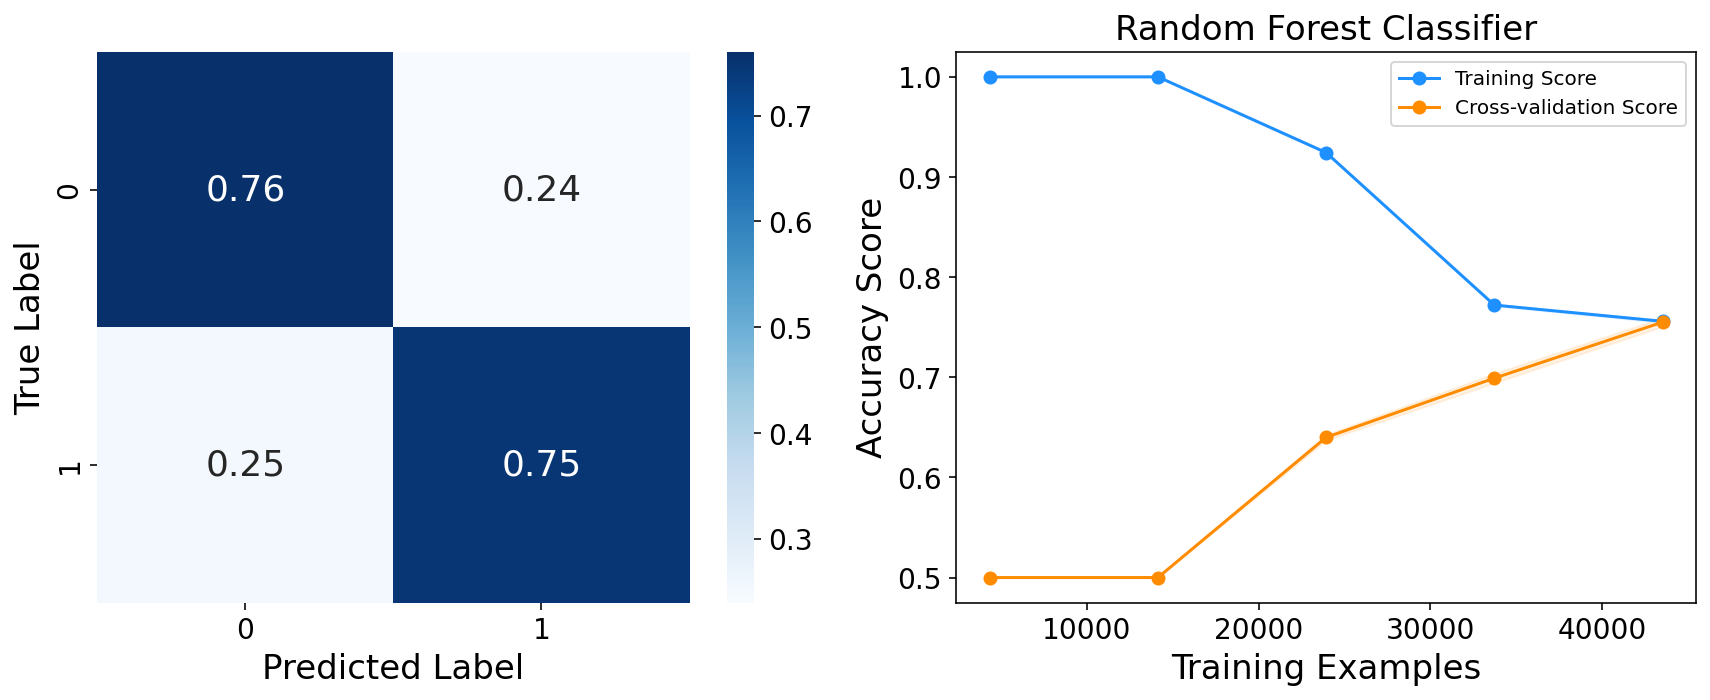

In [47]:
rf = RandomForestClassifier(max_depth = 4, random_state = random_state)

fpr_rf, tpr_rf, auc_rf = clf_performance(rf, 'Random Forest Classifier')

In [48]:
y

0        0
1        0
2        0
3        1
4        1
        ..
89842    0
89843    0
89844    0
89845    0
89847    0
Name: Complaints #, Length: 87017, dtype: int64

XGB
-------------------------------
CV scores:  [0.80483545 0.80924802 0.80272109 0.80334651 0.80610462]
     Mean:  0.805
      STD:  0.002


/home/dingo/.local/lib/python3.10/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/dingo/.local/lib/python3.10/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/dingo/.local/lib/python3.10/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/dingo/.local/lib/python3.10/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/dingo/.local/lib/python3.10/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be suppo

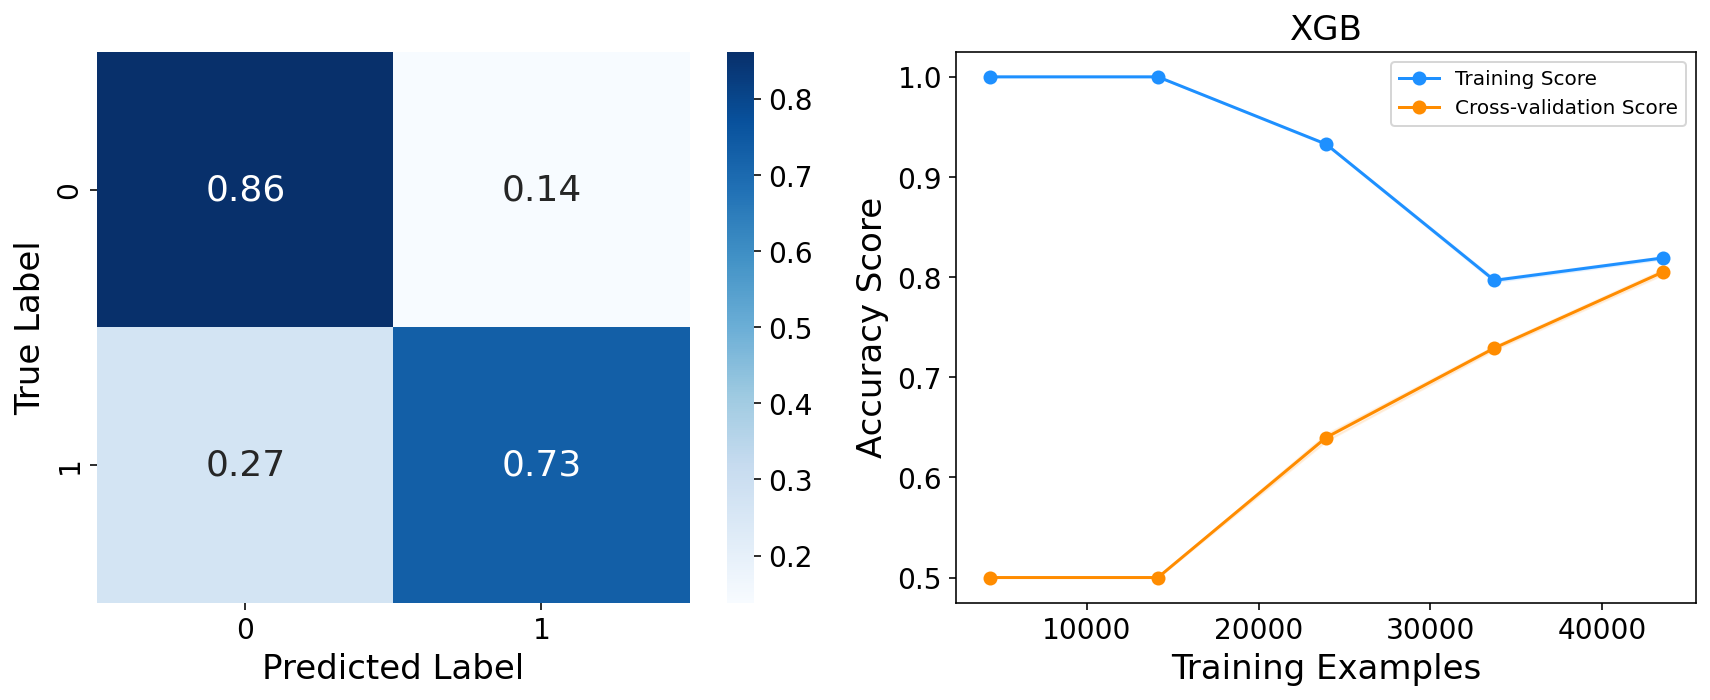

In [49]:
xgb = XGBClassifier(max_depth = 4, random_state = random_state)

fpr_xgb, tpr_xgb, auc_xgb = clf_performance(xgb, 'XGB')

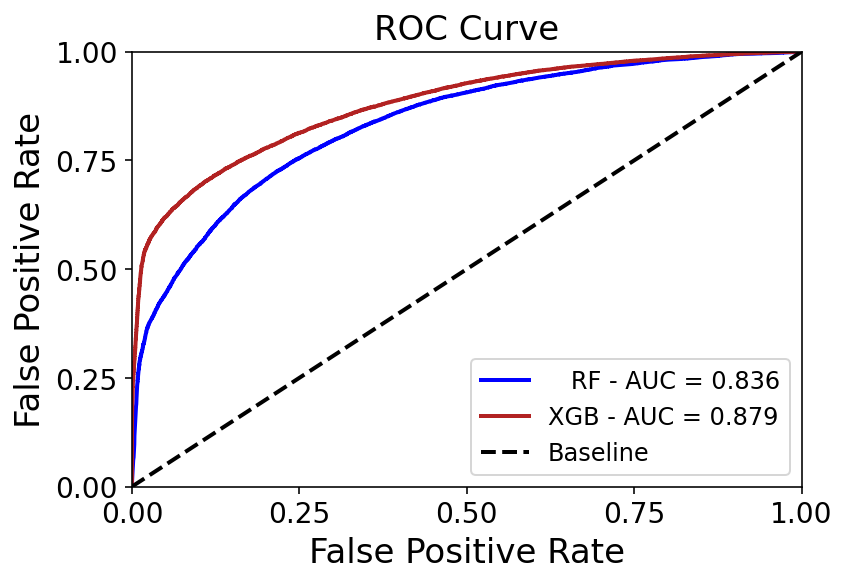

In [50]:
plt.plot(fpr_rf, tpr_rf, color = 'b', lw = 2, label = '   RF - AUC = {}'.format(np.round(auc_rf, 3)))
plt.plot(fpr_xgb, tpr_xgb, color = 'firebrick', lw = 2, label = 'XGB - AUC = {}'.format(np.round(auc_xgb, 3)))

plt.plot([0, 1], [0, 1], 'k--', lw = 2, label = 'Baseline')

plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.xlim([0, 1])
plt.xticks([0, 0.25, 0.5, 0.75, 1])
plt.ylabel('False Positive Rate')
plt.ylim([0, 1])
plt.yticks([0, 0.25, 0.5, 0.75, 1])
plt.legend(fontsize = 12);

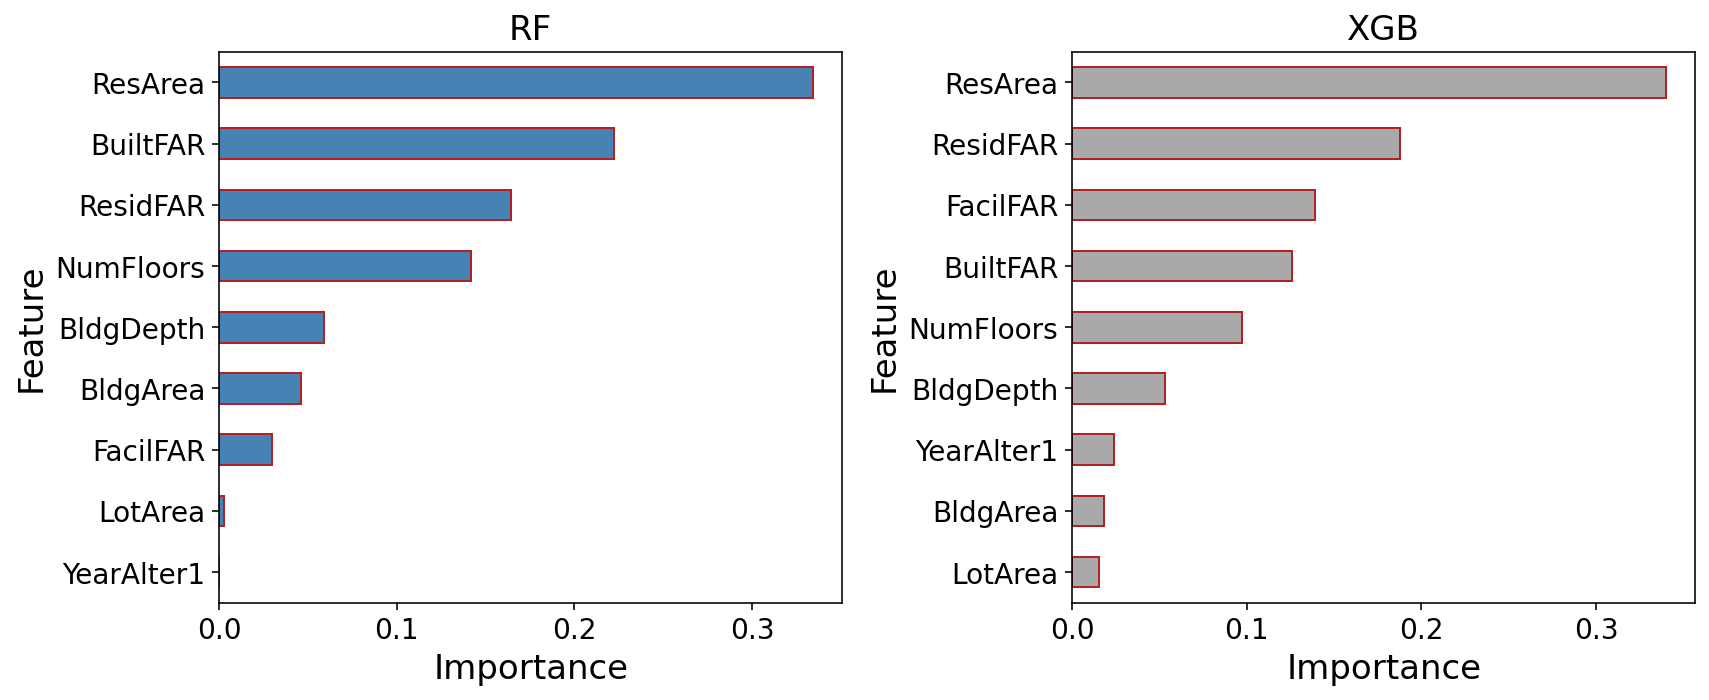

In [51]:
rf.fit(X_train, y_train)
xgb.fit(X_train, y_train);

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 5))

plot_feature_imp(rf, 'RF', 'steelblue', ax1)
plot_feature_imp(xgb, 'XGB', 'darkgray', ax2)

plt.tight_layout();

In [52]:
y_pred = rf.predict(X_test)

print('RF - Accuracy = ', np.round(accuracy_score(y_test, y_pred), 3))

RF - Accuracy =  0.751


In [57]:
y_pred = xgb.predict(X_test)

print('XGB - Accuracy = ', np.round(accuracy_score(y_test, y_pred), 3))
print(y_pred)

XGB - Accuracy =  0.81
[1 0 0 ... 0 1 0]


In [55]:
import joblib

In [56]:
joblib.dump(xgb,'xgb.joblib')

['xgb.joblib']